---
# Predict Future Sales
---
# 0.Context
---
1. 데이터 불러오기
2. Pre-EDA
   - 1.데이터 헤더값 보기
   - 2.shape, null확인
   . 중복값 확인
3. Main-EDA 분석
   - 1.시기별 분석
   - 2.판매량 변화 그래프
   - 3.매장별 분석
4. Feature engineering
   - 1.items & cats에 대해 feature engineering
   - 2.shops에 대해 feature engineering
   - 3.test_train에 대해 feature engineering: outlier 처리(제거)
   - 4.cleaning test data
   - 5.데이터 합치기
   - 6.df_merge에 year&month 열 추가
   - 7.item_cnt_month 열 추가
   - 8.Rolling (이동평균 구하기)으로 열 추가
   - 9.avg_item_cnt_month 열 추가
   - 10.평균관련 열 추가
   - 11.df_merge를 picklize
5. Modeling
   - 1.XGboost
   - 2.catboost
   - 3.Random Forest
   - 4.Linear Regression
   - 5.AdaBoost Regressor
   - 6.LightGBM
   - 7.Ensemble
# 1. 데이터 불러오기

In [63]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
plt.rc('font',family="Malgun Gothic")
import time
import sys
import gc
import pickle
from lightgbm import LGBMRegressor
from sklearn import tree, ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [64]:
#load data
items=pd.read_csv("./data/items.csv")
shops=pd.read_csv("./data/shops.csv")
cats=pd.read_csv("./data/item_categories.csv")
sales_train=pd.read_csv("./data/sales_train.csv")
test=pd.read_csv("./data/test.csv")

# 2. Pre-EDA
## 2.1. 데이터 헤드값 보기

In [65]:
 items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [66]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [67]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [68]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [69]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 각 데이터 head 확인 결과
- items.head()
 - item_name / item_id / item_category_id  
- cats.head()  
 - item_category_name / item_category_id  
- shops.head()  
 - shop_name / shop_id  
- test.head()  
 - shop_id / item_id  

## 2.2. shape, null확인

In [70]:
df_list=[items, shops, cats, sales_train, test]
for i in df_list:
    print('---shape---')
    print(i.shape)
    print()
    print('---null---')
    print(i.isnull().sum())
    print('-' * 22)

---shape---
(22170, 3)

---null---
item_name           0
item_id             0
item_category_id    0
dtype: int64
----------------------
---shape---
(60, 2)

---null---
shop_name    0
shop_id      0
dtype: int64
----------------------
---shape---
(84, 2)

---null---
item_category_name    0
item_category_id      0
dtype: int64
----------------------
---shape---
(2935849, 6)

---null---
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
----------------------
---shape---
(214200, 3)

---null---
ID         0
shop_id    0
item_id    0
dtype: int64
----------------------


-items, shops, cats, sales_train, test는 각각 (22170, 3),(60, 2),(84, 2),(2935849, 6),(214200, 3)이고 결측치는 모두 없다.

## 2.3. 중복값 확인 

In [71]:
#df_list=[items, shops, cats, sales_train, test]

for i in df_list:
    print('-' * 22)
    print(sum(i.duplicated()))
    print()

----------------------
0

----------------------
0

----------------------
0

----------------------
6

----------------------
0



- sales_train에만 중복값이 6개 존재한다.

# 3.Main-EDA 분석
- 각 data를 시각화하여 EDA 분석을 실시한다.

## 3.1. 시기별 분석
### 3.1.1.date 세분화
- 각각의 연,월,일,요일로 이루어진 column을 생성해준다.
- 생성한 column을 이용하여 시기별 판매량을 시각화한다

In [72]:
sales_train['date'] = sales_train['date'].map(lambda x: datetime.strptime(x, '%d.%m.%Y'))
sales_train['year'] = pd.to_datetime(sales_train['date']).dt.year
sales_train['month'] = pd.to_datetime(sales_train['date']).dt.month
sales_train['day'] = pd.to_datetime(sales_train['date']).dt.day
sales_train['days'] = pd.to_datetime(sales_train.date).dt.day_name()
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,days
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,Wednesday
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,Thursday
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,Saturday
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,Sunday
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,Tuesday


### 3.1.2.월간 판매량 

In [73]:
eda_sales = sales_train.copy()
feat_idx = ['date','date_block_num','shop_id', 'item_id','month','day','year','days']
df1 = sales_train.groupby(feat_idx, as_index=False).agg({'item_cnt_day':'sum'})
df1 = df1.rename(columns={'item_cnt_day':'item_cnt_month'})
df1.reset_index(inplace=True)
eda_sales = pd.merge(eda_sales, df1, how='left')

In [74]:
monthly_sum = eda_sales.groupby(['year','month']).agg({'item_cnt_month': 'sum'})
monthly_sum.reset_index(inplace=True)

Text(0, 0.5, '총 판매량')

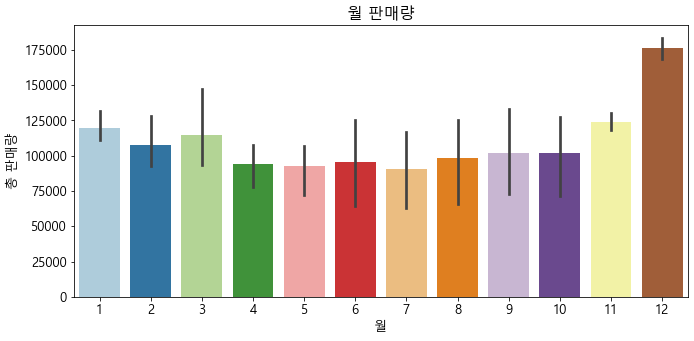

In [75]:
plt.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)
plt.title("월 판매량")
sns.barplot(x='month', y='item_cnt_month', data = monthly_sum, palette='Paired')
plt.xlabel('월')
plt.ylabel('총 판매량')

### 3.1.3.요일별 판매량 

In [76]:
# days별 총 판매량
monthly_days_sum = eda_sales.groupby(['year','days'], as_index=False).agg({'item_cnt_month':'sum'}).sort_values(['year'])
monthly_days_sum.head()

,year,days,item_cnt_month
0,2013,Friday,239355.0
1,2013,Monday,169289.0
2,2013,Saturday,320326.0
3,2013,Sunday,267588.0
4,2013,Thursday,192795.0


In [77]:
#요일별로 정렬하기
from pandas.api.types import CategoricalDtype
weekday_order = CategoricalDtype(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
monthly_days_sum['days'] = monthly_days_sum['days'].astype(weekday_order)

Text(0, 0.5, 'item_cnt_days')

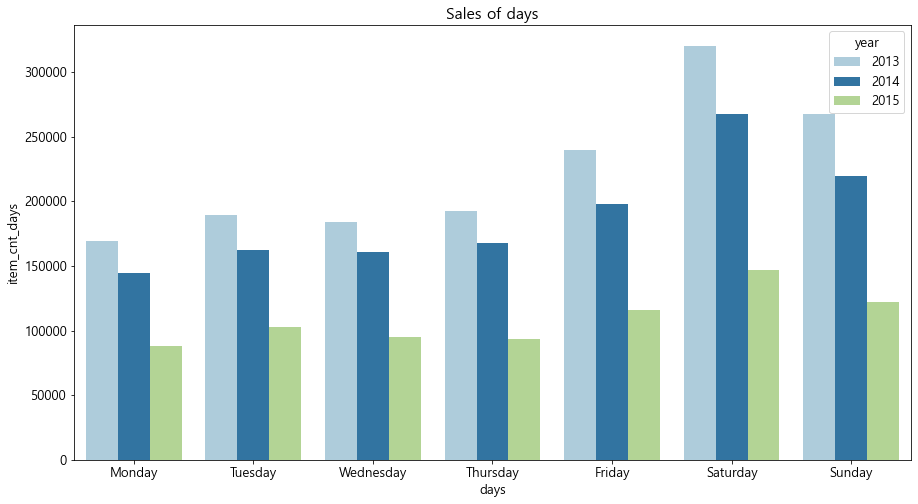

In [78]:
plt.figure(figsize = (15,8))
plt.title("Sales of days")
sns.barplot(x='days', y='item_cnt_month', hue='year', data = monthly_days_sum, palette='Paired')
plt.xlabel('days')
plt.ylabel('item_cnt_days')

### EDA 판매량 평가
- EDA 결과 판매량 top 3 : 1) 12월 2) 11월 3) 1월
- 검색결과 러시아에서는 1월1일, 설날이 최대 명절로 크리스마스를 포함하여 약 7일간의 휴가를 보낸다. 크리스마스는 1월 7일로 원래 12월25일보다 13일 늦은 크리스마스를 지낸다. 따라서 이를 위해 가족, 친구 등 선물등과 파티 용품 등을 많이 구입하는 것으로 소비심리가 12월~1월에 증가한 것으로 보인다. 또한 러시아 거대한 행사인 겨울 축제가 12월 중순에서 1월 중순까지 진행한다. 이로 인해 관광객 등의 유입으로 판매량 증가에 일조한 것으로도 보인다. 
- 11월에는 러시아의 블랙 프라이데이가 있다. 11월 마지막주 금요일이 있는 주에 끝나며 그 전 주부터 시작한다. 총 2주간 진행된다.
- 따라서 이 자료를 통해서 계절성이 있다는 것과 점점 소비자의 소비 심리가 각 년도 대비하여 감소하고 있는 추세를 알 수 있다.

- 연도별 요일 판매량 EDA조사 결과
    - 주말이 시작되는 금요일부터 토요일, 일요일 순으로 판매량이 제일 많은 것으로 보인다
    - 비지니스 측면으로 홍보 및 이벤트를 주말을 위한 것으로 구상하면 좋을 것으로 판단

## 3.2.판매량 변화 그래프
- 시간의 흐름에 따라 변화대는 판매량을 확인한다.

In [79]:
date_block_sum = eda_sales.groupby(["date_block_num"])["item_cnt_month"].sum()
date_block_sum = date_block_sum.astype('float')

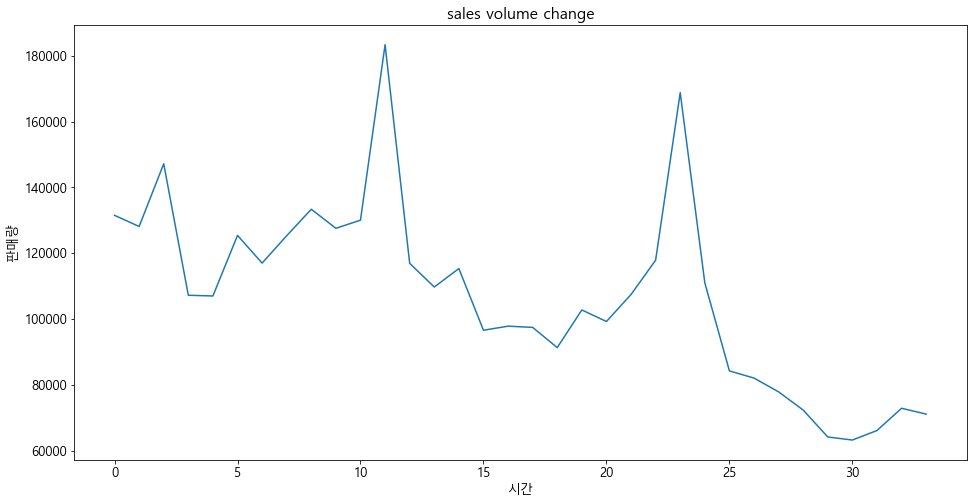

In [80]:
plt.rc('font',family = 'Malgun Gothic')
plt.figure(figsize=(16,8))
plt.title('sales volume change')
plt.xlabel('시간')
plt.ylabel('판매량')
plt.plot(date_block_sum);

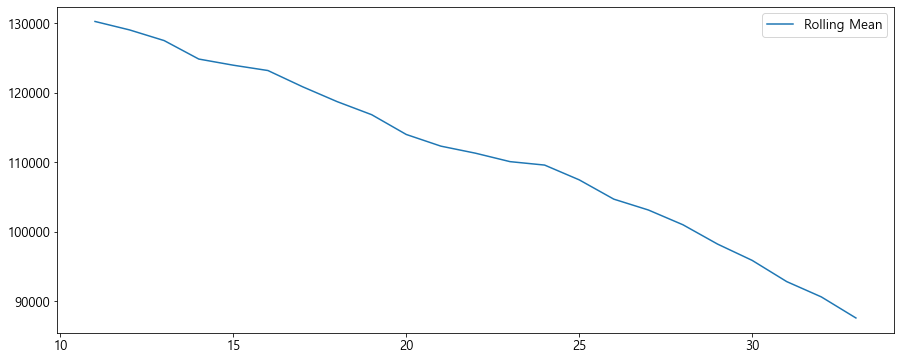

In [81]:
plt.figure(figsize=(15,6))
plt.plot(date_block_sum.rolling(12).mean(),label='Rolling Mean');
plt.legend()

#### 의문점

- 왜 2013년도 2014년도에 비해 2015년도의 판매량이 급격하게 줄었는가?
    - 2014~2015년도에 러시아의 경제 위기가 왔었다. 2014년 기간 러시아 루블 가치가 2013년 대비 절반으로 평가절하가 일어나고 경제가 둔화(소비자 물가 상승과 국민들 실질 가처분 소득 감소). 이로인해 러시아 최대 수출 품목인 석유 가격이 2014년 6월에서 12월동안 50% 이상 감소(루블화 평가 절하로 인해 수출로 인한 이익도 감소). 이로인해 2015년도 연간 경제성장률이 -4%로 침체를 겪음.

## 3.3.매장별 분석
### 3.3.1.매장별 매출과 거래량 비교 

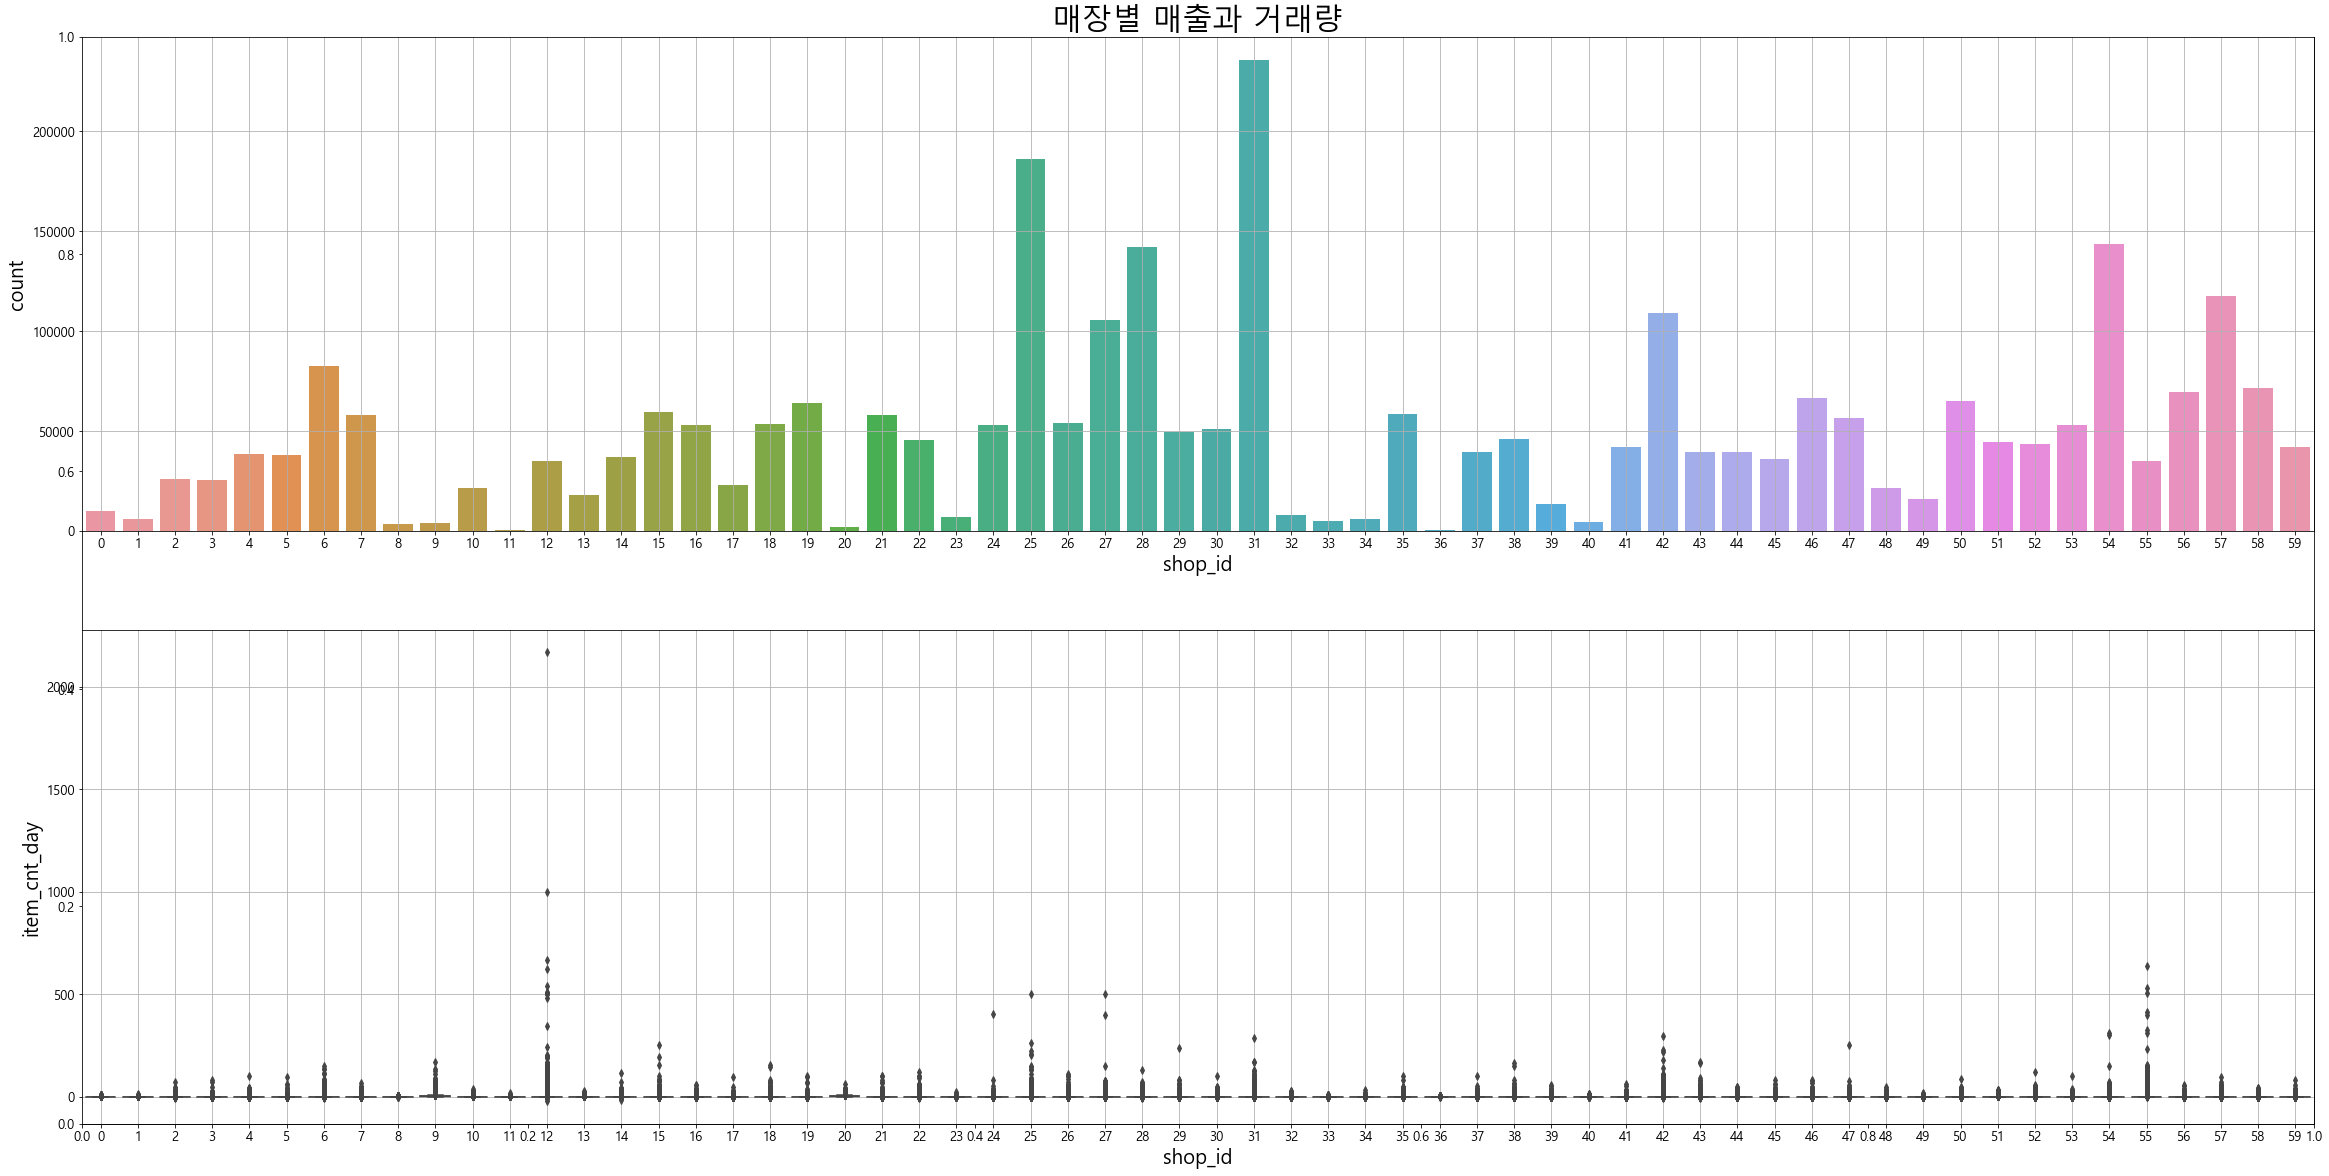

In [82]:
fig = plt.figure(figsize=(40, 20))

plt.title("매장별 매출과 거래량",fontsize=30)

ax1 = fig.add_subplot(2,1,1)
sns.countplot(data = sales_train, x = 'shop_id', ax = ax1)
ax1.set_xlabel("shop_id",fontsize=20)
ax1.set_ylabel("count",fontsize=20)
ax1.grid()

ax2 = fig.add_subplot(2,1,2)
sns.boxplot(data = sales_train, x='shop_id', y='item_cnt_day' , ax = ax2)
ax2.set_xlabel("shop_id",fontsize=20)
ax2.set_ylabel("item_cnt_day",fontsize=20)
ax2.grid()

#### 결과 해석
- 각 매장별로 보여주는 차이로 지역과 인구밀도를 짐작할 수 있다.
- 매장별 판매량 EDA조사 결과
 - 매장별(shop_id)
    - shop_id 31: 모스크바 쇼핑 센터 "Semenovsky" 31
    - shop_id 25: 모스크바 SEC "아트리움" 25
    - shop_id 28: 모스크바 쇼핑 센터 "MEGA Teply Stan" II
    - shop_id 54: 힘키(모스크바주에 있는 도시) 쇼핑 센터 "메가"
    - shop_id 57: 야쿠츠크(러시아 사하 공화국의 수도) 오르조니키제, 56
 - 지역별(city)
    - 모스코바(city:13)
    - 야쿠츠크(러시아 사하 공화국의 수도)(city:29)
    - 상트페테르부르크(러시아의 북서쪽에 있는 연방시)(city:19)
    - 힘키(모스크바주에 있는 도시)(city:26)
 - 위의 결과로 러시아의 수도 중심으로 그 주변 지역의 매장에서 압도적으로 많은 판매량을 보여주고 있다.

# 4. Feature engineering

## 4.1. items & cats에 대해 feature engineering
### 4.1.1. items와 item category 합치기

In [83]:
items = items.join(cats, on='item_category_id', rsuffix='_')
items.head(3)

,item_name,item_id,item_category_id,item_category_name,item_category_id_
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,40


- 아이템과 카테고리를 합한 것에 'item_category_id_'이라는 중복행이 있어 삭제해야 할 필요가 있다.

#### item_category_id_라는 중복행 삭제

In [84]:
items.drop("item_category_id_", axis = 1, inplace= True)
items.head(2)

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)


### 4.1.2. item_type과 item_subtype 열 만들기
#### 러시아 번역(아이템 카테고리)
- Аксессуары -> Accessories
- Билеты -> Tickets
- Игровые консоли -> Game consoles
- Кино -> Cinema
- Игры PC -> PC games

#### 위의 번역에 따라 item_category_name을 ('-') 기준으로 나누기

In [85]:
items['item_category_name'] = items['item_category_name'].str.split('-')
items.head(1)

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,"[Кино , DVD]"


#### item_type열 만들기  

In [86]:
items['item_type'] = items['item_category_name'].map(lambda x: x[0].strip())
items.head(1)

,item_name,item_id,item_category_id,item_category_name,item_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,"[Кино , DVD]",Кино


#### item_subtype열 만들기

In [87]:
# 더욱 세분화 하여 분류 하기
items['item_subtype'] = items['item_category_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items.head(1)

# [1] Для дома и офиса (Цифра) -> For home and office (Digital)
# [22168] Гаджеты, роботы, спорт -> Gadgets, robots, sports

,item_name,item_id,item_category_id,item_category_name,item_type,item_subtype
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,"[Кино , DVD]",Кино,DVD


#### 'item_category_name' 컬럼 drop
- item_type, item_subtype열 만들고  쓸모없어진 item_category_name을 삭제한다.

In [88]:
items.drop('item_category_name', axis = 1, inplace = True)
items.head(1)

,item_name,item_id,item_category_id,item_type,item_subtype
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино,DVD


### 4.1.3. 비정형 데이터 정형화 하기
-  3.a.2.에서 만든 행들의 값을 LabelEncoder로 정형화

#### items['item_type'] 정형화

In [89]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(items['item_type'])
items['item_type_enc'] = le.transform(items['item_type'])
items.head(1)

,item_name,item_id,item_category_id,item_type,item_subtype,item_type_enc
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино,DVD,11


#### items['item_subtype'] 정형화

In [90]:
le = LabelEncoder()
le.fit(items['item_subtype'])
items['item_subtype_enc'] = le.transform(items['item_subtype'])
items.head(1)

,item_name,item_id,item_category_id,item_type,item_subtype,item_type_enc,item_subtype_enc
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино,DVD,11,4


#### 비정형데이터 지우기
- items['item_type']과 items['item_subtype']을 정형데이터화 했기에 기존의 비정형데이터는 쓸모가 없어진다.

In [91]:
items.drop(['item_type','item_subtype'], axis=1, inplace = True)
items.head(1)

,item_name,item_id,item_category_id,item_type_enc,item_subtype_enc
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,11,4


### 4.1.4. 마무리 하기
#### 필요없는 item_name열  지우기

In [92]:
items.drop('item_name', axis=1, inplace=True)
items.head()

,item_id,item_category_id,item_type_enc,item_subtype_enc
0,0,40,11,4
1,1,76,15,31
2,2,40,11,4
3,3,40,11,4
4,4,40,11,4


## 4.2. shops에 대해 feature engineering

In [93]:
shops.head()
# Адыгея ТЦ "Мега" -> 지역[Adygea]아디게아 쇼핑 센터 "Mega"
#Волжский ТЦ "Волга Молл" -> 지역[Volzhsky]볼츠스키 쇼핑 센터 "볼가 몰"
# 공백을 기준으로 (지역, 가게명)으로나뉜 것을 알 수 있었다

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### 4.2.1. shop_name에서 city 분류하기

#### shop_name을 나누기
-shop_name의 [0]의 값을 'city'로 분류하기 위해 split 행만들기

In [94]:
shops['split'] = shops['shop_name'].apply(lambda x: x.split(' '))
shops.head()

,shop_name,shop_id,split
0,"!Якутск Орджоникидзе, 56 фран",0,"[!Якутск, Орджоникидзе,, 56, фран]"
1,"!Якутск ТЦ ""Центральный"" фран",1,"[!Якутск, ТЦ, ""Центральный"", фран]"
2,"Адыгея ТЦ ""Мега""",2,"[Адыгея, ТЦ, ""Мега""]"
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"[Балашиха, ТРК, ""Октябрь-Киномир""]"
4,"Волжский ТЦ ""Волга Молл""",4,"[Волжский, ТЦ, ""Волга, Молл""]"


#### 분류 확인

In [95]:
shops.split[3][0]

'Балашиха'

#### city열 만들기

In [96]:
shops['city'] = shops['split'].apply(lambda x: x[0])
#apply: DataFrame에 전부 적용되게 함
shops.head(1)

,shop_name,shop_id,split,city
0,"!Якутск Орджоникидзе, 56 фран",0,"[!Якутск, Орджоникидзе,, 56, фран]",!Якутск


### 4.2.2. city 정리하기
- shop['city'] == '!Якутск'인 행을 'city' 컬럼에 불러 특수문자를 없애 Якутск으로 변환
- shop_id 수정(리모델링하거나 이전한 shop으로 추정)

In [97]:
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'
shops.loc[shops['shop_id'] == 0, 'shop_id'] = 57
shops.loc[shops['shop_id'] == 1, 'shop_id'] = 58
shops.loc[shops['shop_id'] == 10, 'shop_id'] = 11
shops.loc[shops['shop_id'] == 40, 'shop_id'] = 39

### 4.2.3. city를 정형데이터로 변환

In [98]:

le = LabelEncoder()
le.fit(shops['city'])
shops['city'] = le.transform(shops['city'])
shops.head(1)

,shop_name,shop_id,split,city
0,"!Якутск Орджоникидзе, 56 фран",57,"[!Якутск, Орджоникидзе,, 56, фран]",29


### 4.2.3.shop_name 과 split 제거
- shop_name은 도시를 추출 후 shop_id와 사실상 중복되는 값이고
- spit은 도시를 추출하기 위해 만들었기에 소임을 다했다.

In [99]:
shops.drop(['shop_name', 'split'], axis = 1, inplace =True)
shops.head(1)

,shop_id,city
0,57,29


### 4.2.4. shops에서 알아낸것을 sales_train과 test data에 적용
- sales_train과 test data에도 shop_id가 있으니 shops에서 해주었던 수정을 해줘야 함

#### sales_train의 shop_id

In [100]:
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 40, 'shop_id'] = 39

#### test data의 shop_id

In [101]:
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 40, 'shop_id'] = 39

## 4.3. test_train에 대해 feature engineering: outlier 처리(제거)
### 4.3.1. 이상치 확인

<AxesSubplot:xlabel='item_price'>

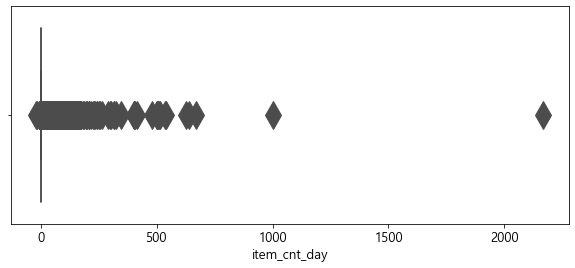

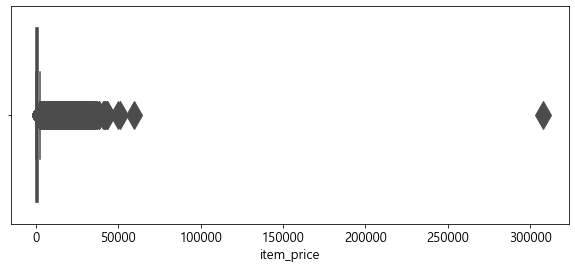

In [102]:
#아이템 판매수
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_cnt_day,  color= 'blue', fliersize=20)

#아이템 가격
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_price,  color= 'blue', fliersize=20)

### 4.3.2. 이상치 제거

In [103]:
# item_cnt_day 이상치 삭제하기 (1000 초과시)
sales_train = sales_train[sales_train['item_cnt_day'] < 1000] 

# item_price 이상치 삭제하기 (50000 초과시)
sales_train = sales_train[sales_train['item_price'] < 50000 ] 

### 4.3.3. 이상치 제거 후 확인

<AxesSubplot:xlabel='item_cnt_day'>

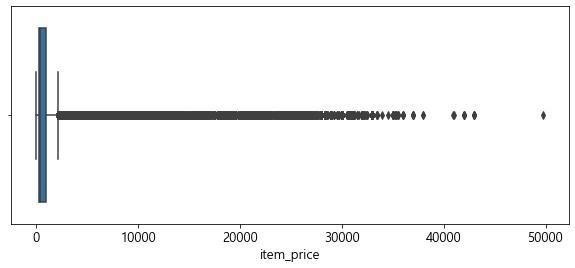

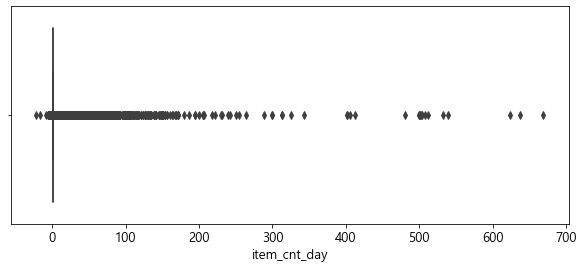

In [104]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_price)

plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_cnt_day)

## 4.4. cleaning test data
### 4.4.1.불필요한 열 제거 및 필요 데이터 생성

In [105]:
test = test.drop('ID', axis=1)
test.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [106]:
test['date_block_num'] = 34
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [107]:
test['date_block_num'] = test['date_block_num'].astype('int')
test['shop_id'] = test.shop_id.astype('int')
test["item_id"] = test.item_id.astype('int')

### 4.4.2. test에만 있는 shop_id&item_id 처리
#### test에만 있는 shop_id&item_id 확인

In [108]:
test_shop_id = test['shop_id'].unique()
test_item_id = test['item_id'].unique()
print(test_shop_id)
print('-'*60)
print(test_item_id)

[ 5  4  6  3  2  7 11 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]
------------------------------------------------------------
[ 5037  5320  5233 ... 15757 19648   969]


#### sales_train에 test에만 있는 shop_id&item_id만 남기기 

In [109]:
# test의 'item_id'는 sales_train의 'item_id'의 부분집합이 아니다 
set(test['item_id'].unique()).issubset(set(sales_train['item_id'].unique())) 

False

In [110]:
test_diff_item = set(test['item_id'].unique()) - set(sales_train['item_id'].unique())
print('test only items:', len(test_diff_item))


test only items: 363


In [111]:
# test의 'shop_id'는 sales_train의 'shop_id'의 부분집합이다 
set(test['shop_id'].unique()).issubset(set(sales_train['shop_id'].unique()))

True

In [112]:
test_diff_shop = set(test['shop_id'].unique()) - set(sales_train['shop_id'].unique())
print('test only shops:', len(test_diff_shop))


test only shops: 0


In [113]:
len(sales_train['shop_id'].unique())-len(test['shop_id'].unique())

14

In [114]:
# test data에만 있는 shop_id 와 item_id
test_only = sales_train[sales_train['shop_id'].isin(test_shop_id)]
test_only = test_only[test_only['item_id'].isin(test_item_id)]

#### 수정 전후 데이터 크기 비교

In [115]:
test_only.drop('date', axis=1, inplace=True)
print('데이타 크기 수정 전:', sales_train.shape[0]) #293만
print('데이타 크기 수정 후:', test_only.shape[0]) #123만

데이타 크기 수정 전: 2935844
데이타 크기 수정 후: 1230909


## 4.5. 데이터 합치기
### 4.5.1. test에 있는 sales_train 과 test 합치기

In [116]:
df_merge = pd.concat([test_only, test], ignore_index=True, sort=False)

In [117]:
df_merge['item_cnt_day'].fillna(0, inplace=True)

In [118]:
df_merge.drop('item_price', axis=1, inplace=True)
df_merge.head(1)

,date_block_num,shop_id,item_id,item_cnt_day,year,month,day,days
0,0,59,22154,1.0,2013.0,1.0,2.0,Wednesday


### 4.5.2. shops를 df_merge와 합치기

In [119]:
df_merge = pd.merge(df_merge, shops, on='shop_id', how='left')

### 4.5.3. items를 df_merge와 합치기

In [120]:
df_merge = pd.merge(df_merge, items, on='item_id', how='left')

### 4.5.4. 중복값 제거

In [121]:
df_merge[df_merge.duplicated() == True]

,date_block_num,shop_id,item_id,item_cnt_day,year,month,day,days,city,item_category_id,item_type_enc,item_subtype_enc
6261,0,57,11081,1.0,2013.0,1.0,6.0,Sunday,29,40,11,4
6263,0,57,10928,1.0,2013.0,1.0,3.0,Thursday,29,55,13,2
6265,0,57,10939,1.0,2013.0,1.0,10.0,Thursday,29,55,13,2
6267,0,57,10945,1.0,2013.0,1.0,18.0,Friday,29,57,13,8
6269,0,57,11012,1.0,2013.0,1.0,6.0,Sunday,29,55,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1576752,34,39,18454,0.0,NaN,NaN,NaN,NaN,18,55,13,2
1576754,34,39,16188,0.0,NaN,NaN,NaN,NaN,18,64,14,42
1576756,34,39,15757,0.0,NaN,NaN,NaN,NaN,18,55,13,2
1576758,34,39,19648,0.0,NaN,NaN,NaN,NaN,18,40,11,4


In [122]:
df_merge.drop_duplicates(inplace=True)
df_merge

,date_block_num,shop_id,item_id,item_cnt_day,year,month,day,days,city,item_category_id,item_type_enc,item_subtype_enc
0,0,59,22154,1.0,2013.0,1.0,2.0,Wednesday,30,37,11,1
1,0,25,2574,2.0,2013.0,1.0,3.0,Thursday,13,55,13,2
2,0,25,2574,1.0,2013.0,1.0,5.0,Saturday,13,55,13,2
3,0,25,2574,1.0,2013.0,1.0,7.0,Monday,13,55,13,2
4,0,25,2574,2.0,2013.0,1.0,8.0,Tuesday,13,55,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1581856,34,45,18454,0.0,NaN,NaN,NaN,NaN,20,55,13,2
1581857,34,45,16188,0.0,NaN,NaN,NaN,NaN,20,64,14,42
1581858,34,45,15757,0.0,NaN,NaN,NaN,NaN,20,55,13,2
1581859,34,45,19648,0.0,NaN,NaN,NaN,NaN,20,40,11,4


## 4.6. df_merge에 year&month 열 추가

In [133]:
df_merge['year'] = df_merge['date_block_num'].apply(lambda x: ((x//12) + 2013))
df_merge['month'] = df_merge['date_block_num'].apply(lambda x: (x % 12)+1)

In [134]:
df_merge.drop(['day','days'], axis =1 , inplace=True)

KeyError: "['day' 'days'] not found in axis"

In [135]:
df_merge

,date_block_num,shop_id,item_id,item_cnt_day,year,month,city,item_category_id,item_type_enc,item_subtype_enc,item_cnt_month,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,59,22154,1.0,2013,1,30,37,11,1,1.0,1.0,1.0,1.000000,0.00000
1,0,25,2574,2.0,2013,1,13,55,13,2,13.0,13.0,13.0,13.000000,0.00000
2,0,25,2574,1.0,2013,1,13,55,13,2,13.0,13.0,13.0,13.000000,0.00000
3,0,25,2574,1.0,2013,1,13,55,13,2,13.0,13.0,13.0,13.000000,0.00000
4,0,25,2574,2.0,2013,1,13,55,13,2,13.0,13.0,13.0,13.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444929,34,45,18454,0.0,2015,11,20,55,13,2,0.0,0.0,1.0,0.666667,0.57735
1444930,34,45,16188,0.0,2015,11,20,64,14,42,0.0,0.0,0.0,0.000000,0.00000
1444931,34,45,15757,0.0,2015,11,20,55,13,2,0.0,0.0,1.0,0.666667,0.57735
1444932,34,45,19648,0.0,2015,11,20,40,11,4,0.0,0.0,0.0,0.000000,0.00000


In [125]:
# 참고: 만약 date를 사용하고 싶으시면 꼭 날짜 형식을 바꿔야 합니다. (원본: 일, 월, 년 순임)
# sales_train['date'] = sales_train['date'].map(lambda x: datetime.strptime(x, '%d.%m.%Y')) # 날짜 순서를 바꾸기

# sales_train['year'] = pd.to_datetime(sales_train['date']).dt.year
# sales_train['month'] = pd.to_datetime(sales_train['date']).dt.month
# sales_train['day'] = pd.to_datetime(sales_train['date']).dt.day
# sales_train['days'] = pd.to_datetime(sales_train.date).dt.day_name() #요일
# sales_train.head()

## 4.7. item_cnt_month 열 추가
### 4.7.1. item _cnt_month  만들기

In [126]:
df1 = df_merge.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
df1.columns= ['item_cnt_month']
df1.reset_index(inplace=True)
df1.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0


### 4.7.2. item_cnt_month merge

In [127]:
df_merge = pd.merge(df_merge, df1, how='left')
df_merge['item_cnt_month'] = (df_merge['item_cnt_month'].clip(0, 30).astype(np.float16))  #30 이상의 값을 30으로 변경

# df.clip(lower=None, upper=None, axis=None, inplace=False, args, kwargs)
# lower : 하한값입니다. 이 이하의 값은 이 값으로 변경
# upper : 상한값입니다. 이 이상의 값은 이 값으로 변경
# axis : 계산할 기준이되는 레이블
# inplace : 따로 지정해주지 않고 바로 저장
df_merge.head()

,date_block_num,shop_id,item_id,item_cnt_day,year,month,day,days,city,item_category_id,item_type_enc,item_subtype_enc,item_cnt_month
0,0,59,22154,1.0,2013,1,2.0,Wednesday,30,37,11,1,1.0
1,0,25,2574,2.0,2013,1,3.0,Thursday,13,55,13,2,13.0
2,0,25,2574,1.0,2013,1,5.0,Saturday,13,55,13,2,13.0
3,0,25,2574,1.0,2013,1,7.0,Monday,13,55,13,2,13.0
4,0,25,2574,2.0,2013,1,8.0,Tuesday,13,55,13,2,13.0


## 4.8. Rolling ( 이동평균 구하기)으로 열 추가
### 4.8.1. f_min, f_max, f_mean, f_std 정의하기[Rolling (window = 3)]

In [128]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

#### df_merge에 feature 만들기

In [129]:
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']
group = ['shop_id', 'item_category_id', 'item_id']

for i in range(len(function_list)):
    df_merge[('item_cnt_%s' % function_name[i])] = df_merge.sort_values(by=['date_block_num']).groupby(group)['item_cnt_month'].apply(function_list[i])

#NaN값을 0으로 채워줌
df_merge['item_cnt_std'].fillna(0, inplace=True)
df_merge.head(1)

,date_block_num,shop_id,item_id,item_cnt_day,year,month,day,days,city,item_category_id,item_type_enc,item_subtype_enc,item_cnt_month,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,59,22154,1.0,2013,1,2.0,Wednesday,30,37,11,1,1.0,1.0,1.0,1.0,0.0


## 4.9. avg_item_cnt_month 열 추가
### 4.9.1.lag 구하는 함수 정의

In [136]:
def lag_feature(df, col, lags):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

### 4.9.2. item_cnt_month 평균

In [137]:
# 평균 item_cnt_month 
df1 = df_merge.groupby(['date_block_num']).agg({'item_cnt_month':'mean'})
df1.columns = ['avg_item_cnt_month']
df1.reset_index(inplace=True)

df_merge = pd.merge(df_merge, df1, on=['date_block_num'], how='left')
df_merge['avg_item_cnt_month'] = df_merge['avg_item_cnt_month'].astype(np.float16)

# 평균 item_cnt shift 1로만 해줌 저번달 데이터를 이번달에만 넣어줌
df_merge = lag_feature(df_merge,'avg_item_cnt_month', [1])
df_merge.drop('avg_item_cnt_month',axis =1, inplace=True)

df_merge.head(1)

,date_block_num,shop_id,item_id,item_cnt_day,year,month,city,item_category_id,item_type_enc,item_subtype_enc,item_cnt_month,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,avg_item_cnt_month_lag1
0,0,59,22154,1.0,2013,1,30,37,11,1,1.0,1.0,1.0,1.0,0.0,NaN


In [139]:
df_merge.drop_duplicates(inplace=True)

## 4.10. 평균관련 열 추가
### 4.10.1. Shop mean 구하기

In [141]:
shop_mean = df_merge.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
shop_mean.columns = ['shop_mean']
shop_mean.reset_index(inplace=True)

### 4.10.2. Item mean 구하기

In [142]:
item_mean = df_merge.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
item_mean.columns = ['item_mean']
item_mean.reset_index(inplace=True)

### 4.10.3. shop & item mean 구하기

In [143]:
shop_item_mean = df_merge.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
shop_item_mean.columns = ['shop_item_mean']
shop_item_mean.reset_index(inplace=True)

### 4.10.4. 연도별 mean 구하기.

In [144]:
year_mean = df_merge.groupby(['year']).agg({'item_cnt_month': ['mean']})
year_mean.columns = ['year_mean']
year_mean.reset_index(inplace=True)

### 4.10.5. 월별 mean 구하기.

In [145]:
month_mean = df_merge.groupby(['month']).agg({'item_cnt_month': ['mean']})
month_mean.columns = ['month_mean']
month_mean.reset_index(inplace=True)

### 4.10.6. df_merge에 mean값들 추가하기

In [146]:
df_merge = pd.merge(df_merge, shop_mean, on='shop_id',how='left')
df_merge = pd.merge(df_merge, item_mean, on='item_id',how='left')
df_merge = pd.merge(df_merge, shop_item_mean, on=['shop_id', 'item_id'],how='left')
df_merge = pd.merge(df_merge, year_mean, on='year',how='left')
df_merge = pd.merge(df_merge, month_mean, on='month',how='left')

### 4.10.7. rolling값 추가하기

In [147]:
df_merge['shop_mean_rol'] = df_merge['shop_mean'].rolling(window=3, min_periods=1).mean()
df_merge['item_mean_rol'] = df_merge['item_mean'].rolling(window=3, min_periods=1).mean()
df_merge['shop_item_mean_rol'] = df_merge['shop_item_mean'].rolling(window=3, min_periods=1).mean()
df_merge['year_mean_rol'] = df_merge['year_mean'].rolling(window=3, min_periods=1).mean()
df_merge['month_mean_rol'] = df_merge['month_mean'].rolling(window=3, min_periods=1).mean()
df_merge.fillna(0, inplace=True)
df_merge.head(2)

,date_block_num,shop_id,item_id,item_cnt_day,year,month,city,item_category_id,item_type_enc,item_subtype_enc,...,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,shop_mean_rol,item_mean_rol,shop_item_mean_rol,year_mean_rol,month_mean_rol
0,0,59,22154,1.0,2013,1,30,37,11,1,...,2.730469,0.609375,0.500000,4.980469,4.117188,2.730469,0.609375,0.500000,4.980469,4.117188
1,0,25,2574,2.0,2013,1,13,55,13,2,...,4.785156,3.302734,8.070312,4.980469,4.117188,3.757812,1.956055,4.285156,4.980469,4.117188


### 4.11. df_merge를 picklize

In [148]:
df_merge.to_pickle('data.pkl')

# 5. Modeling

In [149]:
data = pd.read_pickle('data.pkl')

## 상관관계 분석 후 원하는 feature만 적용

C:\Users\k3vin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\k3vin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


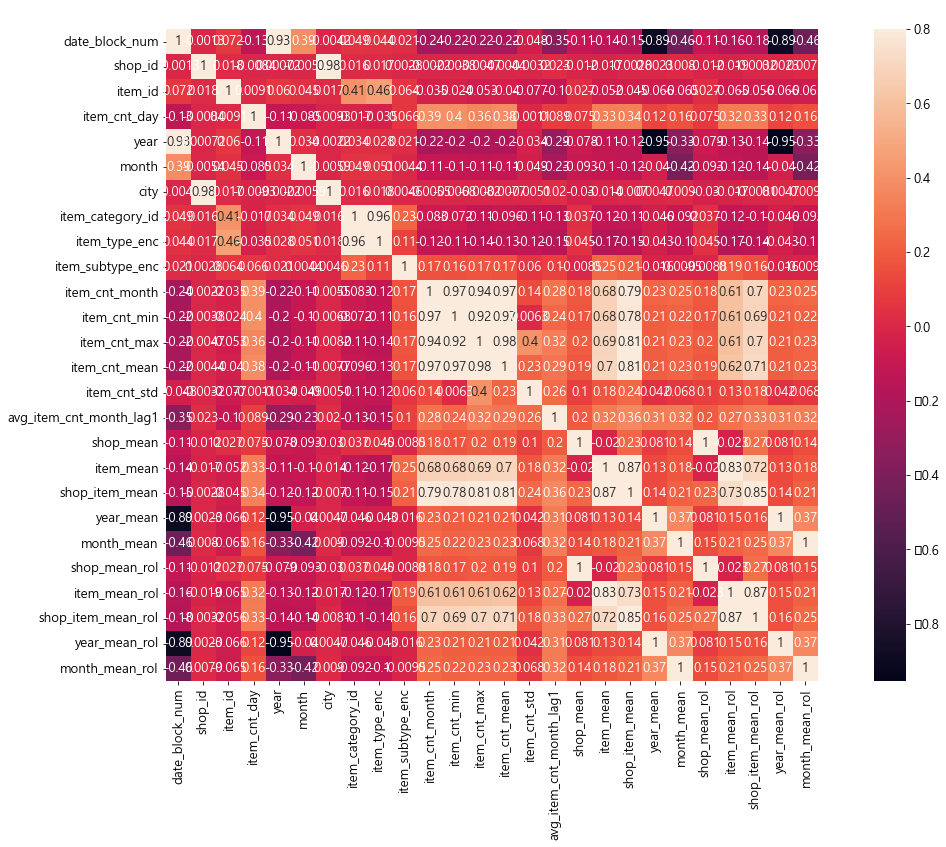

In [150]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corrmat,annot = True, vmax=.8, square=True);
plt.title(" ",fontsize=20)
plt.show()

In [152]:
#원하는 피쳐 제외하세요
data = data[[
    'date_block_num', 
    #'shop_id', 
    #'item_id', 
    #'item_cnt_day', 
    #'city',
    #'item_category_id',
    #'item_type_enc', 
    #'item_subtype_enc', 
    #'year',
    #'month', 
    'item_cnt_month', 
    'item_cnt_min', 
    'item_cnt_max',
    'item_cnt_mean', 
    #'item_cnt_std', 
    #'avg_item_cnt_month_lag1', 
    #'shop_mean',
    'item_mean',
    'shop_item_mean', 
    #'year_mean', 
    #'month_mean',
    #'shop_mean_rol', 
    'item_mean_rol', 
    'shop_item_mean_rol', 
    #'year_mean_rol',
    #'month_mean_rol'
]]

## test & validation & test로 나누기

In [153]:
df_train= data[data['date_block_num']<33]
df_valid= data[data['date_block_num']==33]
df_test= data[data['date_block_num']==34]

x_train = df_train.drop('item_cnt_month', axis=1)
y_train = df_train['item_cnt_month']
x_valid = df_valid.drop('item_cnt_month', axis=1)
y_valid = df_valid['item_cnt_month']
x_test = df_test.drop(['item_cnt_month'], axis=1)

## 5.1 XGboost

### 5.1.1. XGboost 

In [18]:
model = XGBRegressor(
    max_depth=8,          # 한 tree의 최대 깊이 설정, 숫자를 키우면 모델 복잡도가 커져 과적합이 될 수 있음
    n_estimators=1000,    # 생성할 tree의 개수
    min_child_weight=300, # 관측치에 대한 가중치의 합의 최소. 과적합 조절 용도
    colsample_bytree=0.8, # tree 생성에 필요한 feature의 샘플링에 사용. 피쳐가 많을 때 과적합 조절에 사용
    subsample=0.8,        # 데이터 샘플링 비율 지정(과적합 제어)
    eta=0.3,              # learning rate. 트리에 가지가 많을수록 과적합 하기가 쉬워짐 
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:3.84783	validation_1-rmse:2.99670
[1]	validation_0-rmse:2.78742	validation_1-rmse:2.17850
[2]	validation_0-rmse:2.06654	validation_1-rmse:1.62741
[3]	validation_0-rmse:1.59783	validation_1-rmse:1.28249
[4]	validation_0-rmse:1.30602	validation_1-rmse:1.07498
[5]	validation_0-rmse:1.13571	validation_1-rmse:0.96054
[6]	validation_0-rmse:1.03790	validation_1-rmse:0.90128
[7]	validation_0-rmse:0.98333	validation_1-rmse:0.88991
[8]	validation_0-rmse:0.95497	validation_1-rmse:0.88551
[9]	validation_0-rmse:0.93594	validation_1-rmse:0.89270
[10]	validation_0-rmse:0.92590	validation_1-rmse:0.88635
[11]	validation_0-rmse:0.91987	validation_1-rmse:0.88792
[12]	validation_0-rmse:0.91536	validation_1-rmse:0.88698
[13]	validation_0-rmse:0.91209	validation_1-rmse:0.88920
[14]	validation_0-rmse:0.90738	validation_1-rmse:0.90868
[15]	validation_0-rmse:0.90385	validation_1-rmse:0.91473
[16]	validation_0-rmse:0.89890	validation_1-rmse:0.92159
[17]	validation_0-rmse:0.89622	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [19]:
y_pred = model.predict(x_valid).clip(0, 20)
y_test = model.predict(x_test).clip(0, 20)

In [20]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('xgb_submission4.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(y_test, open('xgb_test.pickle', 'wb'))

### 5.1.2. feature importance 확인

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

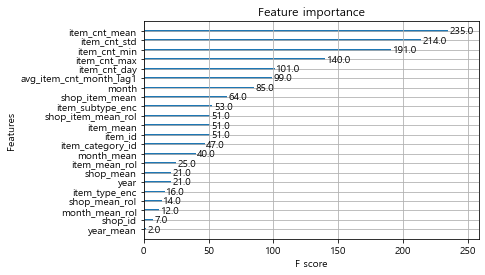

In [10]:
plot_importance(model)

## 5.2 catboost

### 5.2.1. catboost 돌리기

In [217]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    x_train, y_train,
    cat_features=[],
    eval_set=(x_valid, y_valid)
)


Learning rate set to 0.235982
0:	learn: 5.9701027	test: 5.3147388	best: 5.3147388 (0)	total: 290ms	remaining: 2m 24s
50:	learn: 1.0983889	test: 0.9851922	best: 0.9774862 (45)	total: 4.18s	remaining: 36.8s
100:	learn: 1.0653414	test: 0.9618631	best: 0.9618631 (100)	total: 8.29s	remaining: 32.7s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9559235426
bestIteration = 119

Shrink model to first 120 iterations.


### 5.2.2 feature importance 확인

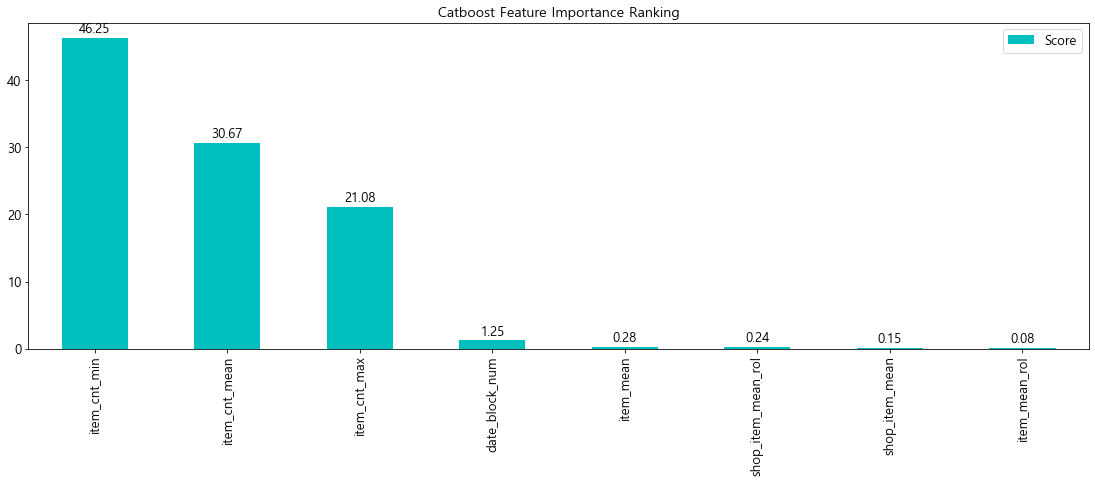

In [218]:
feature_score = pd.DataFrame(list(zip(x_train.dtypes.index, catboost_model.get_feature_importance(Pool(x_train, label=y_train, cat_features=[])))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

### 5.2.3 rmse값 확인

In [219]:
catboost_train_pred = catboost_model.predict(x_train)
catboost_val_pred = catboost_model.predict(x_valid)
catboost_test_pred = catboost_model.predict(x_test)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, catboost_val_pred)))

Train rmse: 1.0557706310835524
Validation rmse: 0.9559235425826185


## 5.3 Random Forest

### 5.3.1 Random Forest 돌리기

In [221]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42, n_jobs=-1)
rf_model.fit(x_train, y_train)


RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=42)

### 5.3.2 rmse값 확인

In [223]:
rf_train_pred = rf_model.predict(x_train)
rf_val_pred = rf_model.predict(x_valid)
rf_test_pred = rf_model.predict(x_test).clip(0, 20)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, rf_val_pred)))

Train rmse: 1.1114324453658115
Validation rmse: 1.0046878025257933


 ## 5.4 Linear Regression

### 5.4.1 스케일링

In [224]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(x_train)
lr_train = lr_scaler.transform(x_train)
lr_val = lr_scaler.transform(x_valid)
lr_test = lr_scaler.transform(x_test)

### 5.4.2 Linear Regression 돌리기

In [226]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, y_train)

LinearRegression(n_jobs=-1)

### 5.4.3 rmse값 확인

In [227]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test).clip(0, 20)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, lr_val_pred)))

Train rmse: 1.1287340366529623
Validation rmse: 1.0188145973327514


## 5.5 AdaBoost Regressor

### 5.5.1 AdaBoost 돌리기

In [232]:
model_ada = AdaBoostRegressor(random_state=42, n_estimators=100)
model_ada.fit(x_train, y_train)


AdaBoostRegressor(n_estimators=100, random_state=42)

### 5.5.2 rmse값 확인

In [234]:
ada_train_pred = model_ada.predict(x_train)
ada_val_pred = rf_model.predict(x_valid)
ada_test_pred = rf_model.predict(x_test).clip(0, 20)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, ada_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, ada_val_pred)))

Train rmse: 1.2771636788726368
Validation rmse: 1.0046878025257933


## 5.6 LightGBM

### 5.6.1 LightGBM 돌리기

In [236]:
model=LGBMRegressor(
        n_estimators=200,
        learning_rate=0.03,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40)
model.fit(x_train, y_train)


Training time, it is...


LGBMRegressor(colsample_bytree=0.9497036, learning_rate=0.03, max_depth=8,
              min_child_weight=40, min_split_gain=0.0222415, n_estimators=200,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.8715623)

###  5.6.2 rmse값 확인

In [238]:
lgbm_train_pred = model.predict(x_train)
lgbm_val_pred = model.predict(x_valid)
lgbm_test_pred = model.predict(x_test).clip(0, 20)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, lgbm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, lgbm_val_pred)))

Train rmse: 1.0081058135830772
Validation rmse: 1.011880769410163


## 5.7 Ensemble


### 5.7.1 train & test  first level 지정

In [248]:
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['adaboost_regression'] = ada_val_pred
first_level['lightGBM'] = lgbm_val_pred
first_level['label'] = y_valid.values

first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['adaboost_regression'] = ada_test_pred
first_level_test['lightGBM'] = lgbm_test_pred

### 5.7.2. second level로 XGboost 지정

In [249]:
meta_model = XGBRegressor(n_jobs=-1)
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, y_valid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### 5.7.3 rmse값 확인

In [250]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, y_valid)))

Train rmse: 0.5590078
